# Confidence Intervals

This notebook overviews three types of intervals that scalecast offers across several model classes and three different datasets. The efficacy of each interval is scored with [Mean Scaled Interval Score (MSIS)](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis). Requires `scalecast>=0.15.9`.  

**Definition of terms:**  

* *Bootstrapped Intervals (default):* 
  - This is a computationally cheap method that works by drawing randomly from in-sample residuals and measuring distance from actual values.  
  - It is not dynamic (interval ranges are constant throughout a given horizon).  
  - Models that are overfit usually get an extremely tight (and inaccurate) confidence interval.  
  - All scalecast models get this interval by default for any model run with `auto_forecast()` or `manual_forecast()`.
  - Models run with `proba_forecast()` receive a probabilistic confidence interval, but that is not overviewed in this notebook.  
* *Naive Intervals:*
  - This method determines a range of possible values within a given certainty for out-of-sample point predictions by measuring how far different model classes' precitions are from one another in each step of a given horizon.  
  - It can create a dynamic interval that expands as predictions move further out.  
  - If you call a diverse set of models on the same series, this method could give a robust interval.  
  - If models are very close to each but very far from an actual value, it will give an interval that is too tight.  
  - If one model is an outlier in how close or far it is from actual values, it can skew all confidence intervals.  
  - In scalecast, it is computationally cheap and has to be called explicitly in order for models to receive it.  
  - In the examples explored in this notebook, **it generally performed better than the default interval.**  
* *Backtest Intervals:*
  - This method determines confidence intervals by backtesting a given model on out-of-sample forecast horizons.
  - The ranges of the resulting confidence intervals are determined by the standard deviation of each step in each backtest iteration.  
  - This is a computationally expensive method but it results in a dynamic interval that is **generally better than the bootstrapped and naive methods.**    
  
Each one of these intervals were better than and worse than the others at times (according to MSIS) depending on the series being forecast and the model. To evaluate the intervals, we leave out a section of each series to score out-of-sample. This is usually not necessary for scalecast, as all models are tested automatically, but the backtest confidence interval can overfit on any test set stored in the `Forecaster` object. Scalecast intervals compared about the same as ARIMA intervals to varying degrees. The series used in this example are ordered from easiest-to-hardest to forecast. Different results could be obtained if certain parameters are changed, such as the model classes used and the number of backtest iterations for that interval type.  

**Sections:**  
[Daily Website Visitors](#Daily-Website-Visitors)  
[Housing Starts](#Housing-Starts)  
[Avocado Sales](#Avocado-Sales)  
[All Aggregated Results](#All-Aggregated-Results)  
[Benchmark Against StatsModels ARIMA](#Benchmark-Against-StatsModels-ARIMA)  

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast import GridGenerator
from scalecast.util import metrics
from scalecast.notebook import tune_test_forecast
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
models = (
    'mlr',
    'elasticnet',
    'ridge',
    'knn',
    'xgboost',
    'lightgbm',
    'gbt',
)

results_template = pd.DataFrame(index=models)

In [3]:
def score_cis(results, fcsts, ci_name, actuals, obs, val_len, models=models, m_=1):
    for m in models:
        results.loc[m,ci_name] = metrics.msis(
            a = actuals,
            uf = fcsts[m+'_upperci'],
            lf = fcsts[m+'_lowerci'],
            obs = obs,
            m = m_,
        )
    return results

In [4]:
GridGenerator.get_example_grids()

## Daily Website Visitors

- Link to data: https://www.kaggle.com/datasets/bobnau/daily-website-visitors  
- We will use a length of 180 observations (about half a year) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 60-day forecast horizon  

In [5]:
val_len = 180
fcst_len = 60

In [6]:
data = pd.read_csv('daily-website-visitors.csv',parse_dates=['Date']).set_index('Date')
data.head()

,Row,Day,Day.Of.Week,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
Date,,,,,,,
2014-09-14,1,Sunday,1,"2,146","1,582",1430,152
2014-09-15,2,Monday,2,"3,621","2,528",2297,231
2014-09-16,3,Tuesday,3,"3,698","2,630",2352,278
2014-09-17,4,Wednesday,4,"3,667","2,614",2327,287
2014-09-18,5,Thursday,5,"3,316","2,366",2130,236


In [7]:
visits_sep = data['First.Time.Visits'].iloc[-fcst_len:]
visits = data['First.Time.Visits'].iloc[:-fcst_len]

In [8]:
f=Forecaster(
    y=visits,
    current_dates=visits.index,
    future_dates=fcst_len
)
f.set_test_length(val_len)
f.set_validation_length(val_len)
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2014-09-14T00:00:00.000000000
    DateEndActuals=2020-06-20T00:00:00.000000000
    Freq=D
    N_actuals=2107
    ForecastLength=60
    Xvars=['t', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98', 'AR99', 'AR100']
    Differenced=0
    TestLe

In [9]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
ms = f.export('model_summaries',determine_best_by='TestSetMAE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','TestSetMAE','InSampleMAE']]

,ModelNickname,TestSetMAE,InSampleMAE
0,xgboost,345.792972,11.628271
1,lightgbm,461.362673,85.150035
2,elasticnet,541.722274,139.726881
3,ridge,543.778908,139.716351
4,mlr,547.506781,140.103644
5,knn,671.790741,217.559589
6,gbt,824.240540,113.251078


We will demonstrate how the confidence intervals change as they are re-evaluated using the best model according to the test MAE: xgboost.

### Bootstrapped Interval (default)

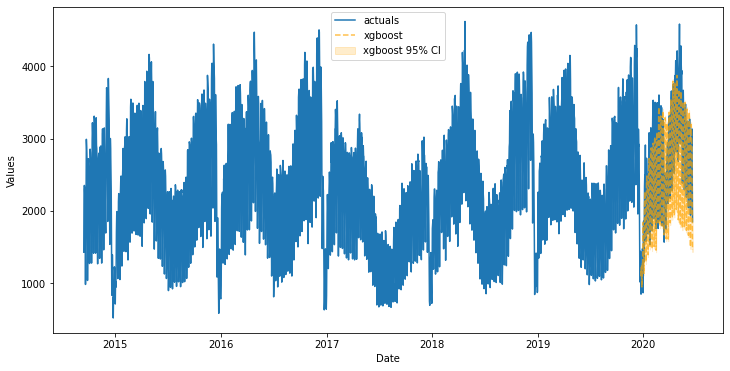

In [11]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

XGBoost overfit on this dataset, so its default confidence interval is barely noticeable. That is one of the downsides of the bootstrapped method from in-sample residuals.

In [12]:
# export test-set preds and confidence intervals
fcsts1 = f.export("lvl_fcsts",cis=True)
fcsts1.head()

,DATE,xgboost,xgboost_upperci,xgboost_lowerci,lightgbm,lightgbm_upperci,lightgbm_lowerci,elasticnet,elasticnet_upperci,elasticnet_lowerci,...,ridge_lowerci,mlr,mlr_upperci,mlr_lowerci,knn,knn_upperci,knn_lowerci,gbt,gbt_upperci,gbt_lowerci
0,2020-06-21,2028.825562,2058.412090,1999.239033,2198.858468,2430.694318,1967.022617,2199.951838,2571.298659,1828.605016,...,1790.732538,2190.555279,2606.753684,1774.356875,2080.476190,2613.844764,1547.107617,2125.968510,2431.559089,1820.377932
1,2020-06-22,2720.898438,2750.484966,2691.311909,2820.575637,3052.411487,2588.739786,2837.629387,3208.976209,2466.282565,...,2432.877112,2835.674158,3251.872562,2419.475753,2962.142857,3495.511430,2428.774284,2729.050006,3034.640584,2423.459428
2,2020-06-23,2845.472412,2875.058940,2815.885884,2819.654176,3051.490026,2587.818325,2963.220499,3334.567321,2591.873677,...,2572.976818,2975.510723,3391.709128,2559.312319,3038.095238,3571.463811,2504.726665,2900.134825,3205.725403,2594.544247
3,2020-06-24,2904.729492,2934.316021,2875.142964,2824.992206,3056.828056,2593.156355,3026.889266,3398.236087,2655.542444,...,2635.783419,3038.258157,3454.456561,2622.059752,3128.095238,3661.463811,2594.726665,2930.293895,3235.884473,2624.703317
4,2020-06-25,2986.020996,3015.607524,2956.434468,2961.588543,3193.424394,2729.752693,3024.266925,3395.613747,2652.920104,...,2625.022286,3032.580568,3448.778973,2616.382164,2796.857143,3330.225716,2263.488570,3029.007375,3334.597953,2723.416797


The values in the below table are [mean scaled interval scores](https://scalecast.readthedocs.io/en/latest/Forecaster/Util.html#src.scalecast.util.metrics.msis) for confidence intervals. Lower scores are better.

In [13]:
results = score_cis(
    results_template.copy(),
    fcsts1,
    'Bootstrapped (Default)',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default)
mlr,3.735276
elasticnet,3.985959
ridge,3.792264
knn,3.676863
xgboost,21.798800
lightgbm,12.876613
gbt,7.048014


### Naive Interval

- `Forecaster.reeval_cis()` [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.reeval_cis)  

In [14]:
%%time
f.reeval_cis()

Wall time: 1.8 s


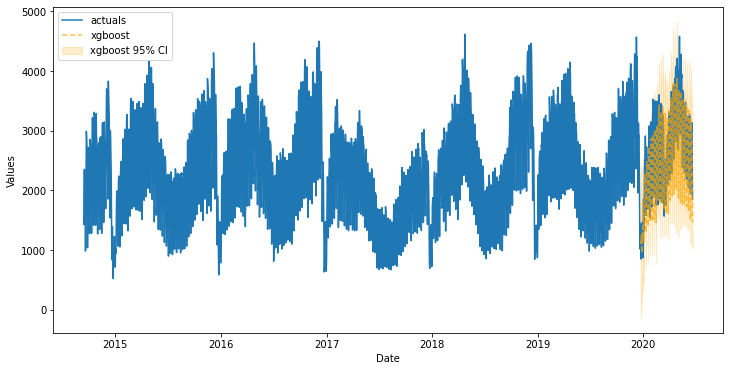

In [15]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

The confidence interval is noticeable now and is dynamic -- for some observations it is further out from the point estimate than others. It has been constructed based on the dispersion of the point estimates from the other evaluated models.

In [16]:
fcsts2 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts2,
    'Naive',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive
mlr,3.735276,5.557534
elasticnet,3.985959,5.510432
ridge,3.792264,5.532083
knn,3.676863,4.123050
xgboost,21.798800,6.532479
lightgbm,12.876613,7.180746
gbt,7.048014,5.214716


### Backtested Interval

In [17]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 3min 9s


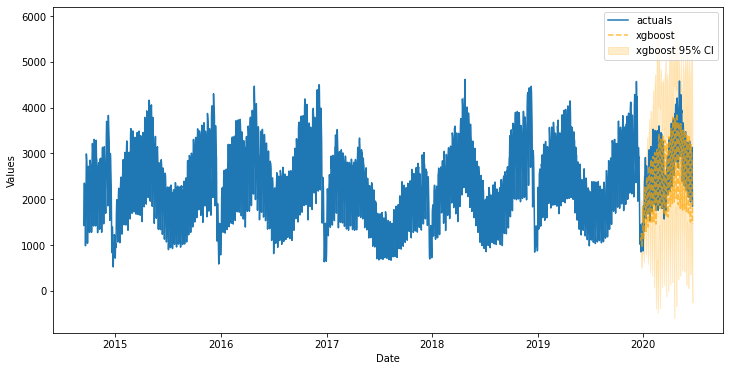

In [18]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

This is also a dynamic confidence interval, but is obtained solely from XGBoost's own point estimates over 10 test sets in the data. The first point's interval is based on the standard deviation of the residual for all 10 tests of the first step, same for the second point and beyond.  

In [19]:
fcsts3 = f.export("lvl_fcsts",cis=True)
results = score_cis(
    results,
    fcsts3,
    'Backtest',
    visits_sep,
    visits,
    val_len = val_len,
)
results

,Bootstrapped (Default),Naive,Backtest
mlr,3.735276,5.557534,4.795872
elasticnet,3.985959,5.510432,4.789591
ridge,3.792264,5.532083,4.801673
knn,3.676863,4.123050,4.515227
xgboost,21.798800,6.532479,5.129796
lightgbm,12.876613,7.180746,4.587335
gbt,7.048014,5.214716,5.274736


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For website visitors, it was the backtest method.  

In [20]:
ci_type_score = results.mean()
ci_type_score.sort_values()

Backtest                  4.842033
Naive                     5.664434
Bootstrapped (Default)    8.130541
dtype: float64

In [21]:
model_score = results.mean(axis=1)
model_score.sort_values()

knn            4.105047
mlr            4.696227
ridge          4.708673
elasticnet     4.761994
gbt            5.845822
lightgbm       8.214898
xgboost       11.153691
dtype: float64

## Housing Starts  

- Link to data: https://fred.stlouisfed.org/series/HOUSTNSA  
- We will use a length of 96 observations (8 years) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 24-month forecast horizon  

In [22]:
import pandas_datareader as pdr

In [23]:
val_len = 96
fcst_len = 24

In [24]:
housing = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2021-06-01')

In [25]:
starts_sep = housing.iloc[-fcst_len:,0]
starts = housing.iloc[:-fcst_len,0]

In [26]:
f = Forecaster(
    y=starts,
    current_dates=starts.index,
    future_dates=fcst_len,
)

f.set_test_length(val_len)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=100,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2019-06-01T00:00:00.000000000
    Freq=MS
    N_actuals=726
    ForecastLength=24
    Xvars=['monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91', 'AR92', 'AR93', 'AR94', 'AR95', 'AR96', 'AR97', 'AR98'

In [27]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [28]:
ms = f.export('model_summaries',determine_best_by='LevelTestSetMAE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','LevelTestSetMAE','LevelInSampleMAE']]

,ModelNickname,LevelTestSetMAE,LevelInSampleMAE
0,xgboost,18.511642,2.230892
1,lightgbm,20.756320,22.575723
2,mlr,24.520401,60.741758
3,knn,40.900595,123.571497
4,ridge,41.370245,46.585394
5,elasticnet,49.169948,30.500771
6,gbt,89.936888,33.189330


### Bootstrapped Interval (default)

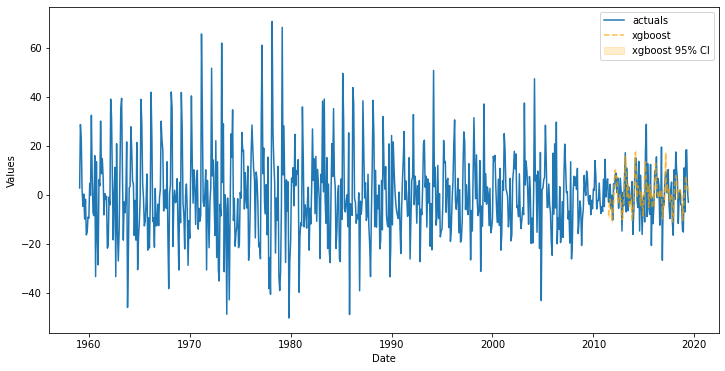

In [29]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

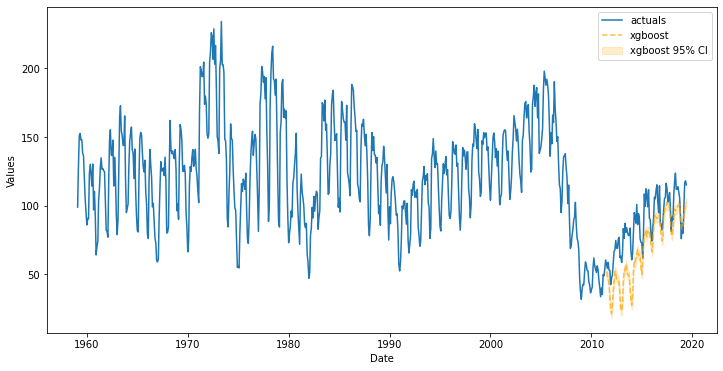

In [30]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [31]:
housing_fcsts1 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    results_template.copy(),
    housing_fcsts1,
    'Bootstrapped (Default)',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12, # monthly seasonality
)
housing_results

,Bootstrapped (Default)
mlr,7.549399
elasticnet,5.555597
ridge,8.221404
knn,33.303897
xgboost,28.886851
lightgbm,6.285528
gbt,4.441993


### Naive Interval

In [32]:
%%time
f.reeval_cis()

Wall time: 622 ms


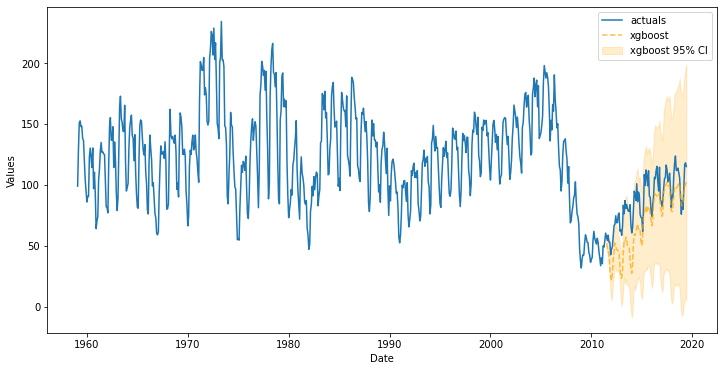

In [33]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [34]:
housing_fcsts2 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts2,
    'Naive',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive
mlr,7.549399,38.033614
elasticnet,5.555597,28.980547
ridge,8.221404,32.613185
knn,33.303897,33.118914
xgboost,28.886851,21.399262
lightgbm,6.285528,21.800084
gbt,4.441993,24.608178


### Backtested Interval

In [35]:
%%time
f.reeval_cis(method='backtest',jump_back=fcst_len)

Wall time: 1min 2s


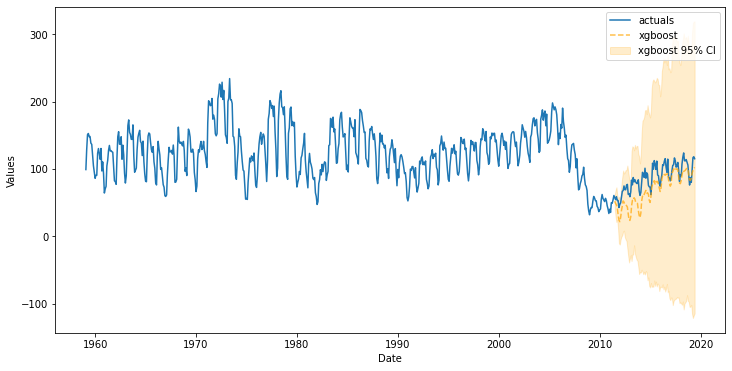

In [36]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [37]:
housing_fcsts3 = f.export("lvl_fcsts",cis=True)
housing_results = score_cis(
    housing_results,
    housing_fcsts3,
    'Backtest',
    starts_sep,
    starts,
    val_len = val_len,
    m_ = 12,
)
housing_results

,Bootstrapped (Default),Naive,Backtest
mlr,7.549399,38.033614,6.491399
elasticnet,5.555597,28.980547,4.887020
ridge,8.221404,32.613185,5.825845
knn,33.303897,33.118914,5.335474
xgboost,28.886851,21.399262,5.121770
lightgbm,6.285528,21.800084,4.651980
gbt,4.441993,24.608178,5.083580


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For housing starts, it was the backtest method.  

In [38]:
housing_ci_type_score = housing_results.mean()
housing_ci_type_score.sort_values()

Backtest                   5.342438
Bootstrapped (Default)    13.463524
Naive                     28.650540
dtype: float64

In [39]:
housing_model_score = housing_results.mean(axis=1)
housing_model_score.sort_values()

lightgbm      10.912531
gbt           11.377917
elasticnet    13.141055
ridge         15.553478
mlr           17.358137
xgboost       18.469294
knn           23.919428
dtype: float64

## Avocado Sales  

- Link to data: https://www.kaggle.com/datasets/neuromusic/avocado-prices.  
- We will use a length of 13 observations (1 quarter) both to tune and test the models  
- We want to optimize the forecasts and confidence intervals for a 13-week forecast horizon  

In [40]:
val_len = 13
fcst_len = 13

In [41]:
avocados = pd.read_csv('avocado.csv',parse_dates = ['Date'])
volume = avocados.groupby('Date')['Total Volume'].sum()

In [42]:
volume_sep = volume.iloc[-fcst_len:]
volume = volume.iloc[:-fcst_len]

In [43]:
f = Forecaster(
    y = volume,
    current_dates = volume.index,
    future_dates = 13,
)

f.set_test_length(fcst_len)
f.set_validation_length(val_len)
f.diff()
f.auto_Xvar_select(
    estimator='elasticnet',
    alpha=.2,
    max_ar=26,
    monitor='ValidationMetricValue', # not test set
)
f

Forecaster(
    DateStartActuals=2015-01-04T00:00:00.000000000
    DateEndActuals=2017-12-24T00:00:00.000000000
    Freq=W-SUN
    N_actuals=156
    ForecastLength=13
    Xvars=['weeksin', 'weekcos', 'monthsin', 'monthcos', 'quartersin', 'quartercos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26']
    Differenced=1
    TestLength=13
    ValidationLength=13
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

In [44]:
tune_test_forecast(
    f,
    models,
    dynamic_testing = fcst_len,
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [45]:
ms = f.export('model_summaries',determine_best_by='LevelTestSetMAPE')
best_model = ms['ModelNickname'].values[0]
ms[['ModelNickname','LevelTestSetMAPE','LevelInSampleMAPE']]

,ModelNickname,LevelTestSetMAPE,LevelInSampleMAPE
0,mlr,0.080165,0.623597
1,ridge,0.151771,0.095394
2,gbt,0.155505,0.023354
3,elasticnet,0.156035,0.086360
4,lightgbm,0.157319,0.118893
5,knn,0.189670,0.958267
6,xgboost,0.203372,0.000488


### Bootstrapped Interval (default)

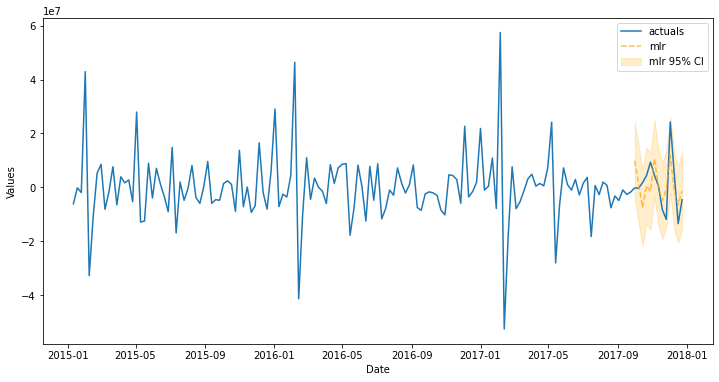

In [46]:
f.plot_test_set(ci=True,models=best_model)
plt.show()

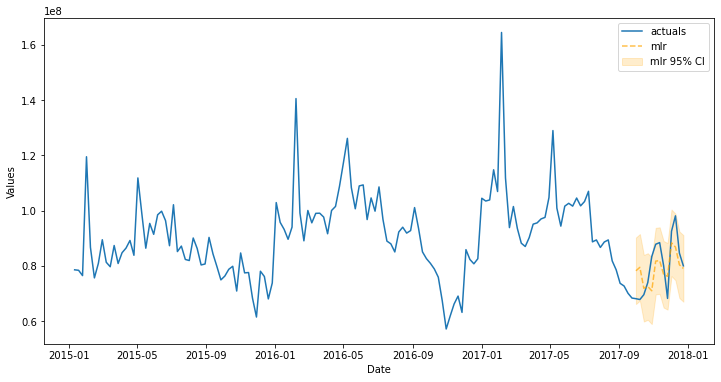

In [47]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [48]:
avc_fcsts1 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    results_template.copy(),
    avc_fcsts1,
    'Bootstrapped (Default)',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default)
mlr,57.814260
elasticnet,38.434091
ridge,34.909917
knn,45.516602
xgboost,85.302684
lightgbm,30.743642
gbt,79.374065


### Naive Interval

In [49]:
%%time
f.reeval_cis()

Wall time: 153 ms


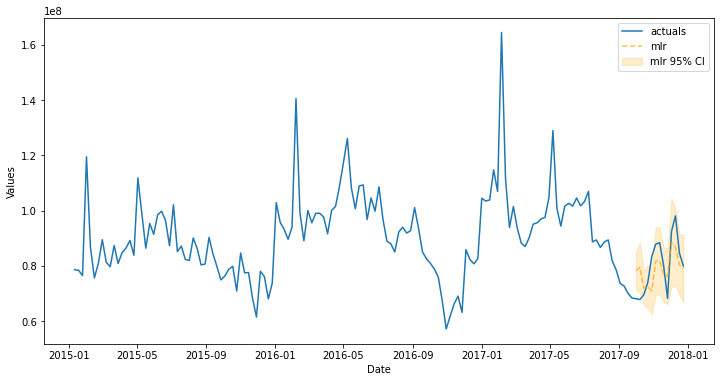

In [50]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [51]:
avc_fcsts2 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts2,
    'Naive',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive
mlr,57.814260,38.641485
elasticnet,38.434091,38.840462
ridge,34.909917,35.883668
knn,45.516602,19.310109
xgboost,85.302684,27.410728
lightgbm,30.743642,29.609831
gbt,79.374065,34.027556


### Backtested Interval

In [52]:
%%time
f.reeval_cis(method='backtest')

Wall time: 11.6 s


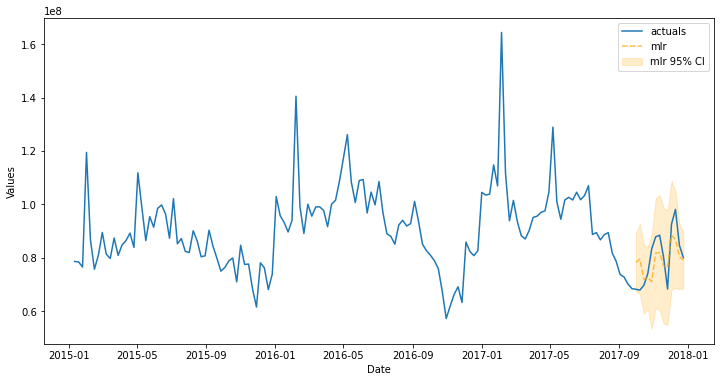

In [53]:
f.plot_test_set(ci=True,models=best_model,level=True)
plt.show()

In [54]:
avc_fcsts3 = f.export("lvl_fcsts",cis=True)
avc_results = score_cis(
    avc_results,
    avc_fcsts3,
    'Backtest',
    volume_sep,
    volume,
    val_len = val_len,
    models = models,
)
avc_results

,Bootstrapped (Default),Naive,Backtest
mlr,57.814260,38.641485,49.213370
elasticnet,38.434091,38.840462,40.200960
ridge,34.909917,35.883668,33.985652
knn,45.516602,19.310109,39.059037
xgboost,85.302684,27.410728,21.850633
lightgbm,30.743642,29.609831,24.031343
gbt,79.374065,34.027556,28.487145


### Aggregated Results  

- Which type generally led to the best MSIS score?  
- For avocados, it was the naive method.  

In [55]:
avc_ci_type_score = avc_results.mean()
avc_ci_type_score.sort_values()

Naive                     31.960548
Backtest                  33.832592
Bootstrapped (Default)    53.156466
dtype: float64

In [56]:
avc_model_score = avc_results.mean(axis=1)
avc_model_score.sort_values()

lightgbm      28.128272
knn           34.628583
ridge         34.926412
elasticnet    39.158504
xgboost       44.854682
gbt           47.296255
mlr           48.556372
dtype: float64

## All Aggregated Results
- All MSIS scores for each model on each series are stored in the below dataframe.

In [57]:
all_results = {
    'visitors':results,
    'housing starts':housing_results,
    'avocados':avc_results
}

all_results_df = pd.DataFrame()
for k, df in all_results.items():
    df['forecast of'] = k
    all_results_df = pd.concat(
        [all_results_df,df]
    )
    
all_results_df

,Bootstrapped (Default),Naive,Backtest,forecast of
mlr,3.735276,5.557534,4.795872,visitors
elasticnet,3.985959,5.510432,4.789591,visitors
ridge,3.792264,5.532083,4.801673,visitors
knn,3.676863,4.123050,4.515227,visitors
xgboost,21.798800,6.532479,5.129796,visitors
lightgbm,12.876613,7.180746,4.587335,visitors
gbt,7.048014,5.214716,5.274736,visitors
mlr,7.549399,38.033614,6.491399,housing starts
elasticnet,5.555597,28.980547,4.887020,housing starts
ridge,8.221404,32.613185,5.825845,housing starts


In [58]:
all_results_df.mean().sort_values()

Backtest                  14.672354
Naive                     22.091841
Bootstrapped (Default)    24.916844
dtype: float64

Generally speaking, the backtest interval was the best, followed by naive, followed by bootstrapped. All three of them were fairly close to one another.  

In [59]:
models_pivoted = pd.pivot_table(
    all_results_df.reset_index(),
    index = 'index',
    values = all_results_df.columns.to_list()[:-1],
    aggfunc = np.mean,
    sort = False,
)
models_pivoted

,Bootstrapped (Default),Naive,Backtest
index,,,
mlr,23.032978,27.410878,20.166880
elasticnet,15.991882,24.443813,16.625857
ridge,15.641195,24.676312,14.871057
knn,27.499121,18.850691,16.303246
xgboost,45.329445,18.447490,10.700733
lightgbm,16.635261,19.530220,11.090219
gbt,30.288024,21.283483,12.948487


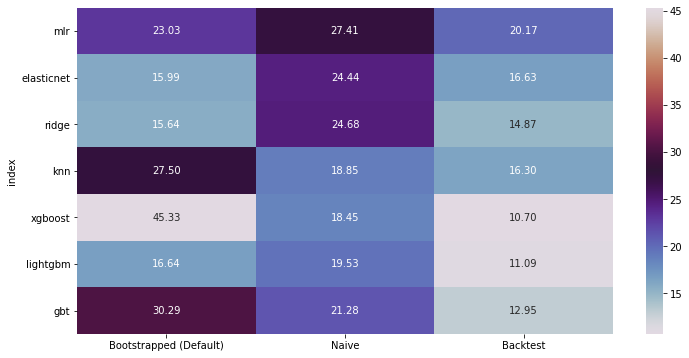

In [60]:
_, ax = plt.subplots(figsize=(12,6))
sns.heatmap(
    models_pivoted,
    annot=True,
    fmt='.2f',
    cmap="twilight",
    ax=ax
)
plt.show()

Bootstrapped intervals seem to have a good or bad score, without a lot in the middle. Naive is more in the middle of the three methods and most of the backtest intervals score well.

## Benchmark Against StatsModels ARIMA
- Confidence intervals come from StatsModels but the auto-ARIMA process is from [PMDARIMA](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima).

In [61]:
from scalecast.auxmodels import auto_arima

In [62]:
all_series = {
    # series,out-of-sample series,seasonal step
    'visitors':[visits,visits_sep,1],
    'housing starts':[starts,starts_sep,12],
    'avocados':[volume,volume_sep,1]
}
arima_benchmark_results = pd.DataFrame()

In [63]:
for k, v in all_series.items():
    print(k)
    f = Forecaster(
        y=v[0],
        current_dates=v[0].index,
        future_dates=len(v[1])
    )
    auto_arima(f,m=v[2])
    cis = f.regr.get_forecast(len(v[1])).conf_int()
    arima_benchmark_results.loc[k,'MSIS'] = metrics.msis(
        a = v[1].values,
        uf = cis.T[1],
        lf = cis.T[0],
        obs = v[0].values,
        m = v[2],
    )

visitors
housing starts
avocados


In [64]:
arima_benchmark_results

,MSIS
visitors,5.790405
housing starts,5.624713
avocados,29.509452


In [65]:
arima_benchmark_results.mean()

MSIS    13.641523
dtype: float64

In [76]:
def highlight_rows(row):
    lightgreen = 'background-color: lightgreen;'
    highlight = 'background-color: lightcoral;'
    default = ''
    ret_row = [default]*4
    for i, c in enumerate(all_results_df.iloc[:,:-1]):
        if row[c] < row['ARIMA']:
            ret_row[i] = lightgreen
        else:
            ret_row[i] = highlight
    return ret_row


all_results_df_arima = all_results_df.merge(
    arima_benchmark_results.reset_index(),
    left_on='forecast of', 
    right_on = 'index', 
    how = 'left'
)

all_results_df_arima = all_results_df_arima.rename({'MSIS':'ARIMA'},axis=1)
all_results_df_arima = all_results_df_arima[all_results_df.columns.to_list()[:-1] + ['ARIMA']]
all_results_df_arima.index = all_results_df.reset_index()[['index','forecast of']].apply(lambda x: '-'.join(x),axis=1)

all_results_df_arima.style.apply(
    highlight_rows,
    axis=1
)

,Bootstrapped (Default),Naive,Backtest,ARIMA
mlr-visitors,3.735276,5.557534,4.795872,5.790405
elasticnet-visitors,3.985959,5.510432,4.789591,5.790405
ridge-visitors,3.792264,5.532083,4.801673,5.790405
knn-visitors,3.676863,4.123050,4.515227,5.790405
xgboost-visitors,21.798800,6.532479,5.129796,5.790405
lightgbm-visitors,12.876613,7.180746,4.587335,5.790405
gbt-visitors,7.048014,5.214716,5.274736,5.790405
mlr-housing starts,7.549399,38.033614,6.491399,5.624713
elasticnet-housing starts,5.555597,28.980547,4.887020,5.624713
ridge-housing starts,8.221404,32.613185,5.825845,5.624713


The above table shows which scalecast intervals performed better or worse than the ARIMA interval. It would seem sometimes a scalecast interval leads to better results than ARIMA would, sometimes not. Usually backtesting does. The other two methods usually do not. It is up to the user to use common sense to decide in what situations to use which confidence interval type.

When a series is transformed before forecasting, it can lead to a more distorted interval in scalecast. We saw that with the housing and avocados series. A nice seasonal and stationary series like the visitors series explored in this notebook can receive a more sound interval using less work to get it.